In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import solver2 as solver

# Example of a basic neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_fn=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size        # Input size 
        self.num_hidden = len(hidden_sizes) # Number of hidden layers
        self.hidden_sizes = hidden_sizes    # Hidden layer sizes
        self.output_size = output_size      # Output size

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(activation_fn)
        for i in range(1, self.num_hidden):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.layers.append(activation_fn)
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

        initialization_method = None
        if isinstance(activation_fn, nn.ReLU):
            initialization_method = 'kaiming'
        elif isinstance(activation_fn, (nn.Tanh, nn.Sigmoid)):
            initialization_method = 'xavier'
        self._initialize_weights(method=initialization_method)
        
    def _initialize_weights(self, method):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if method == 'kaiming':
                    nn.init.kaiming_uniform_(layer.weight)
                elif method == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Epoch 1/10000 Loss: 3.0612680912017822
Epoch 2/10000 Loss: 2.569505453109741
Epoch 3/10000 Loss: 1.8252227306365967
Epoch 4/10000 Loss: 1.3045326471328735
Epoch 5/10000 Loss: 0.9957677125930786
Epoch 6/10000 Loss: 0.873367190361023
Epoch 7/10000 Loss: 0.8959084749221802
Epoch 8/10000 Loss: 1.0065979957580566
Epoch 9/10000 Loss: 1.139189600944519
Epoch 10/10000 Loss: 1.2509324550628662
Epoch 11/10000 Loss: 1.3106837272644043
Epoch 12/10000 Loss: 1.311570167541504
Epoch 13/10000 Loss: 1.2619471549987793
Epoch 14/10000 Loss: 1.1782348155975342
Epoch 15/10000 Loss: 1.0808476209640503
Epoch 16/10000 Loss: 0.9888709187507629
Epoch 17/10000 Loss: 0.9152258038520813
Epoch 18/10000 Loss: 0.8647386431694031
Epoch 19/10000 Loss: 0.8459963798522949
Epoch 20/10000 Loss: 0.8197885155677795
Epoch 21/10000 Loss: 0.6665921807289124
Epoch 22/10000 Loss: 0.3892972767353058
Epoch 23/10000 Loss: 0.41677048802375793
Epoch 24/10000 Loss: 0.43282178044319153
Epoch 25/10000 Loss: 0.43432947993278503
Epoch 26/1

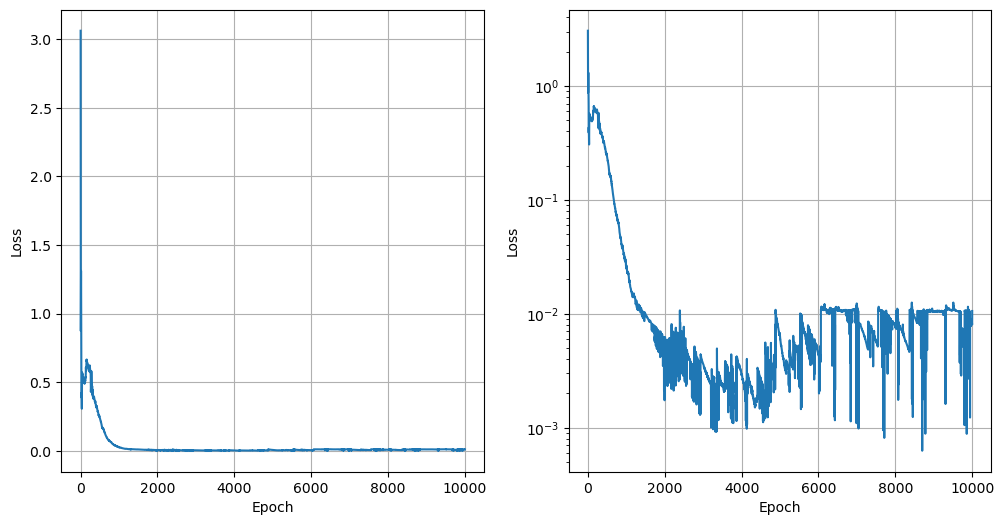

In [2]:
# Example 1 
# f'(x) + f(x) + x - 1 = 0, f(0) = 0
# Analytical solution f(x) = 2 - 2 e^(-x) - x

def differential(x, f):
    x = x.requires_grad_(True) # Required in order to compute grad of f, the model, w.r.t. x
    f_x = f(x)
    f_x_prime = autograd.grad(f_x, x, torch.ones_like(x), create_graph=True)[0]
    return f_x_prime + f_x + x - 1

def boundary(xb, f):
    return f(xb)

xb = torch.tensor([0.0], requires_grad=True)
bc_tuple = (boundary, xb)

loss_fn = solver.LossFunction(differential, [bc_tuple])
domain = torch.linspace(0, 2, 100).reshape(-1, 1)

model = NeuralNetwork(1, [200], 1)

# loss_fn(model, torch.tensor([0.0]).reshape(-1, 1)) # Example how to call the loss function

epochs = 10000
lr = 0.001
loss_data = solver.train(model, loss_fn, domain, epochs, lr, print_progress=True)


fid, ax = plt.subplots(1, 2, figsize=(12, 6))

# Loss data plot
ax[0].plot(np.arange(epochs), loss_data)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

# Loss data log plot
ax[1].plot(np.arange(epochs), loss_data)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].grid(True)

plt.show()

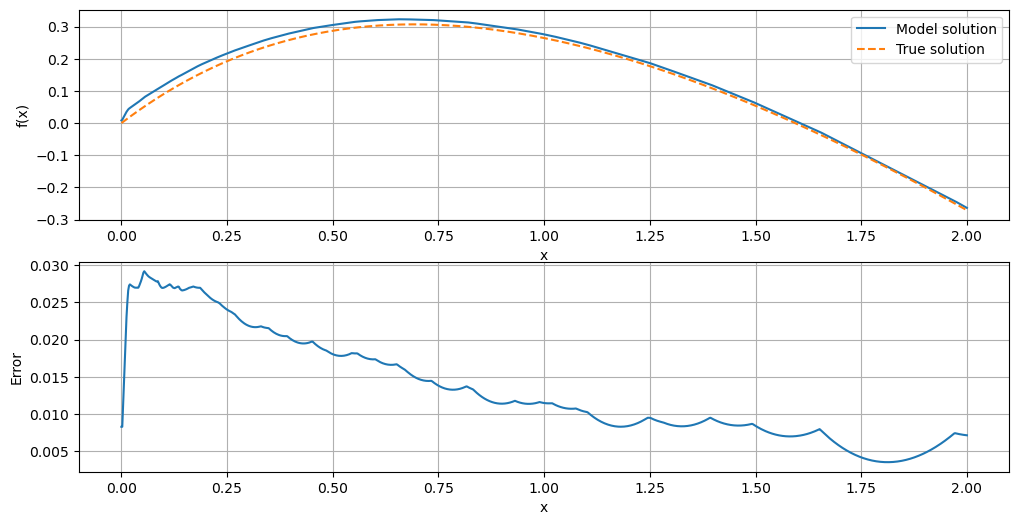

In [3]:
domain_eval = torch.linspace(0, 2, 1000).reshape(-1, 1)
model.eval()
model_eval = model(domain_eval).detach().numpy()

domain_eval_numpy = domain_eval.numpy()
true_solution = 2 - 2 * np.exp(-domain_eval_numpy) - domain_eval_numpy

fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Model solution and true solution plot
ax[0].plot(domain_eval_numpy, model_eval, label='Model solution')
ax[0].plot(domain_eval_numpy, true_solution, label='True solution', linestyle='--')
ax[0].set_xlabel('x')
ax[0].set_ylabel('f(x)')
ax[0].grid(True)
ax[0].legend()

# Error plot
error = np.abs(model_eval - true_solution)
ax[1].plot(domain_eval_numpy, error)
ax[1].set_xlabel('x')
ax[1].set_ylabel('Error')
ax[1].grid(True)

plt.show()